# <center> Trajectory of a particle under the action of a magnetic field calculation </center>
<center> Cálculo da trajetóra de uma partícula sob ação de um campo magnético </center>

## Data

In [1]:
''' ==== características da partícula ==== '''
m = 939.3      # massa da partícula (em MeV/c²)
q = 1          # carga da patícula (em C)


''' ==== condições iniciais ==== '''
x0, y0, z0 = 0, 0, 0     # posição inicial (em m)
v_direction = [1, 0, 0]
Ec0 = 2        # energia cinética da partícula (em MeV)


''' ==== passo de tempo e tempo total ==== '''
step = 1e-11      # passo de tempo (usado no método RK4)
total_t = 1e-8      # tempo total da simulação (em s)


''' ==== deseja salvar os dados? ==== '''
output_file = True
txt_name = "Teste_01"


''' ==== deseja visualizar os gráficos? ==== '''
output_graphic = True

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy.interpolate
from scipy.interpolate import RectBivariateSpline

## Functions

In [3]:
# função que define o campo magnético em cada coordenada
def b_field(x, y, z): 
    Bx = 0
    By = 0
    Bz = 1.6
    return Bx, By, Bz

# função que define o campo elétrico em cada coordenada
def e_field(x, y, z): 
    Ex = 1e3
    Ey = 0.3
    Ez = 0
    return Ex, Ey, Ez

## Main

In [4]:
def main_func(m, q, x0, y0, z0, b_field, e_field, Ec0, v_direction, step, total_t, output_file, txt_name):

    c = 2.99792458e8      # vel. da luz (em m/s)

    
    conv_m = m * 1.78266e-30      # massa convertida (em Kg)
    conv_q = q * 1.60218e-19        # carga convertida (em C)
    const = conv_q/conv_m


    gamma = 1.0 + (Ec0 / m)

    conv_v = (np.sqrt(1.0 - 1.0/(gamma**2))) * c  # velocidade convertida (em m/s)


    ux = v_direction[0]
    uy = v_direction[1]
    uz = v_direction[2]
    u = np.array([ux, uy, uz], dtype=float)
    u_hat = u / np.linalg.norm(u)
    Vx, Vy, Vz = conv_v * u_hat          # velocidades em x, y e z (em m/s)

    x, y, z = x0, y0, z0       # posição inicial



    def acceleration(x, y, z, Vx, Vy, Vz):
        Bx, By, Bz = b_field(x, y, z)
        Ex, Ey, Ez = e_field(x, y, z)

        V2 = Vx**2 + Vy**2 + Vz**2           # velocidade ao quadrado
        if V2 >= c**2:
            gamma = 1.0e10 
        else:
            gamma = 1.0 / np.sqrt(1.0 - V2/c**2)
    
        ax2 = const/gamma*((Ex+Vy*Bz-Vz*By)-((Vx/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        ay2 = const/gamma*((Ey+Vz*Bx-Vx*Bz)-((Vy/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        az2 = const/gamma*((Ez+Vx*By-Vy*Bx)-((Vz/c**2)*Vx*Ex+Vy*Ey+Vz*Ez))
        return ax2, ay2, az2

    
    def rk4(x, y, z, Vx, Vy, Vz, step): 
        # k1
        ax1, ay1, az1 = acceleration(x, y, z, Vx, Vy, Vz)
        k1_x = Vx        
        k1_y = Vy        
        k1_z = Vz         
        k1_Vx = ax1     
        k1_Vy = ay1      
        k1_Vz = az1        
    
        # k2 
        x2 = x + 0.5*step * k1_x
        y2 = y + 0.5*step * k1_y
        z2 = z + 0.5*step * k1_z
        Vx2 = Vx + 0.5*step * k1_Vx
        Vy2 = Vy + 0.5*step * k1_Vy
        Vz2 = Vz + 0.5*step * k1_Vz
    
        ax2, ay2, az2 = acceleration(x2, y2, z2, Vx2, Vy2, Vz2)
        k2_x = Vx2   
        k2_y = Vy2
        k2_z = Vz2
        k2_Vx = ax2
        k2_Vy = ay2
        k2_Vz = az2
    
        # k3 
        x3 = x + 0.5*step * k2_x
        y3 = y + 0.5*step * k2_y
        z3 = z + 0.5*step * k2_z
        Vx3 = Vx + 0.5*step * k2_Vx
        Vy3 = Vy + 0.5*step * k2_Vy
        Vz3 = Vz + 0.5*step * k2_Vz
    
        ax3, ay3, az3 = acceleration(x3, y3, z3, Vx3, Vy3, Vz3)
        k3_x = Vx3
        k3_y = Vy3
        k3_z = Vz3
        k3_Vx = ax3
        k3_Vy = ay3
        k3_Vz = az3
    
        # k4
        x4 = x + step * k3_x
        y4 = y + step * k3_y
        z4 = z + step * k3_z
        Vx4 = Vx + step * k3_Vx
        Vy4 = Vy + step * k3_Vy
        Vz4 = Vz + step * k3_Vz
    
        ax4, ay4, az4 = acceleration(x4, y4, z4, Vx4, Vy4, Vz4)
        k4_x = Vx4
        k4_y = Vy4
        k4_z = Vz4
        k4_Vx = ax4
        k4_Vy = ay4
        k4_Vz = az4
    
        novo_x = x + (step/6.0) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
        novo_y = y + (step/6.0) * (k1_y + 2*k2_y + 2*k3_y + k4_y)
        novo_z = z + (step/6.0) * (k1_z + 2*k2_z + 2*k3_z + k4_z)
        novo_Vx = Vx + (step/6.0) * (k1_Vx + 2*k2_Vx + 2*k3_Vx + k4_Vx)
        novo_Vy = Vy + (step/6.0) * (k1_Vy + 2*k2_Vy + 2*k3_Vy + k4_Vy)
        novo_Vz = Vz + (step/6.0) * (k1_Vz + 2*k2_Vz + 2*k3_Vz + k4_Vz)
    
        return novo_x, novo_y, novo_z, novo_Vx, novo_Vy, novo_Vz


    x_vals = np.zeros(int(total_t/step))
    y_vals = np.zeros(int(total_t/step))
    z_vals = np.zeros(int(total_t/step))
    Vx_vals = np.zeros(int(total_t/step))
    Vy_vals = np.zeros(int(total_t/step))
    Vz_vals = np.zeros(int(total_t/step))
    t_vals = np.zeros(int(total_t/step))

    
    for i in range(int(total_t/step)):
        x_vals[i], y_vals[i], z_vals[i] = x, y, z
        Vx_vals[i], Vy_vals[i], Vz_vals[i] = Vx, Vy, Vz
        t_vals[i] = i*step
    
        x, y, z, Vx, Vy, Vz = rk4(x, y, z, Vx, Vy, Vz, step)


    data = np.column_stack((x_vals, y_vals, z_vals, Vx_vals, Vy_vals, Vz_vals, t_vals))

    if output_file:
        df = pd.DataFrame(data, columns=['x(m)', 'y(m)', 'z(m)', 'Vx(m/s)', 'Vy(m/s)', 'Vz(m/s)', 't(s)'])
    
        df.to_csv(f"{txt_name}.csv", index=False, float_format='%.12e')
    
        np.savetxt(f"{txt_name}.txt", data, 
               fmt='%.12e', delimiter=',', 
               header='x(m),y(m),z(m),Vx(m/s),Vy(m/s),Vz(m/s),t(s)',
               comments='')


    if output_graphic == True:
        fig = plt.figure(figsize=(15, 15))

        ax1 = fig.add_subplot(321) 
        ax2 = fig.add_subplot(322) 
        ax3 = fig.add_subplot(323) 
        ax4 = fig.add_subplot(324) 

        tempo = np.linspace(0, total_t, int(total_t/step)) 

        ax1.plot(df['x(m)'], df['y(m)'], 'palevioletred', linewidth=1.5, alpha=0.7)
        ax1.plot(x_vals[0], y_vals[0], 'mo', markersize=10, label='Início')
        ax1.plot(x_vals[-1], y_vals[-1], 'co', markersize=10, label='Fim')
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.legend()
        ax1.grid(True)
        ax1.axis('equal')
        ax1.set_title('Trajetória em XY')

        ax2.plot(df['x(m)'], tempo, 'sandybrown', linewidth=1.5, alpha=0.7) 
        ax2.set_xlabel('Tempo')
        ax2.set_ylabel('Coordenadas em X')
        ax2.grid(True)
        ax2.set_title('Trajetória em X por tempo')

        ax3.plot(df['y(m)'], tempo, 'mediumaquamarine', linewidth=1.5, alpha=0.7)
        ax3.set_xlabel('Coordenadas em Y')
        ax3.set_ylabel('Tempo')
        ax3.grid(True)
        ax3.set_title('Trajetória em Y por tempo')

        ax4.plot(df['z(m)'], tempo, 'teal', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Coordenadas em Z')
        ax4.set_ylabel('Tempo')
        ax4.grid(True)
        ax4.set_title('Trajetória em Z por tempo')

        plt.tight_layout()
        plt.show()

        fig = go.Figure()

        fig.add_trace(go.Scatter3d(
            x=df['x(m)'],
            y=df['y(m)'],
            z=df['z(m)'],
            mode='markers',
            marker=dict(
                size=5,
                color=z_vals, 
                colorscale='tealrose',
                opacity=0.8,
                colorbar=dict(title='Posição z (m)')
            )
        ))

        fig.update_layout(
            title='Trajetória em XYZ',
            scene=dict(
                xaxis_title='x (m)',
                yaxis_title='y (m)',
                zaxis_title='z (m)',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=800,
            height=600,
            margin=dict(r=20, l=10, b=10, t=40)
        )

        fig.show()
    
    return "done"

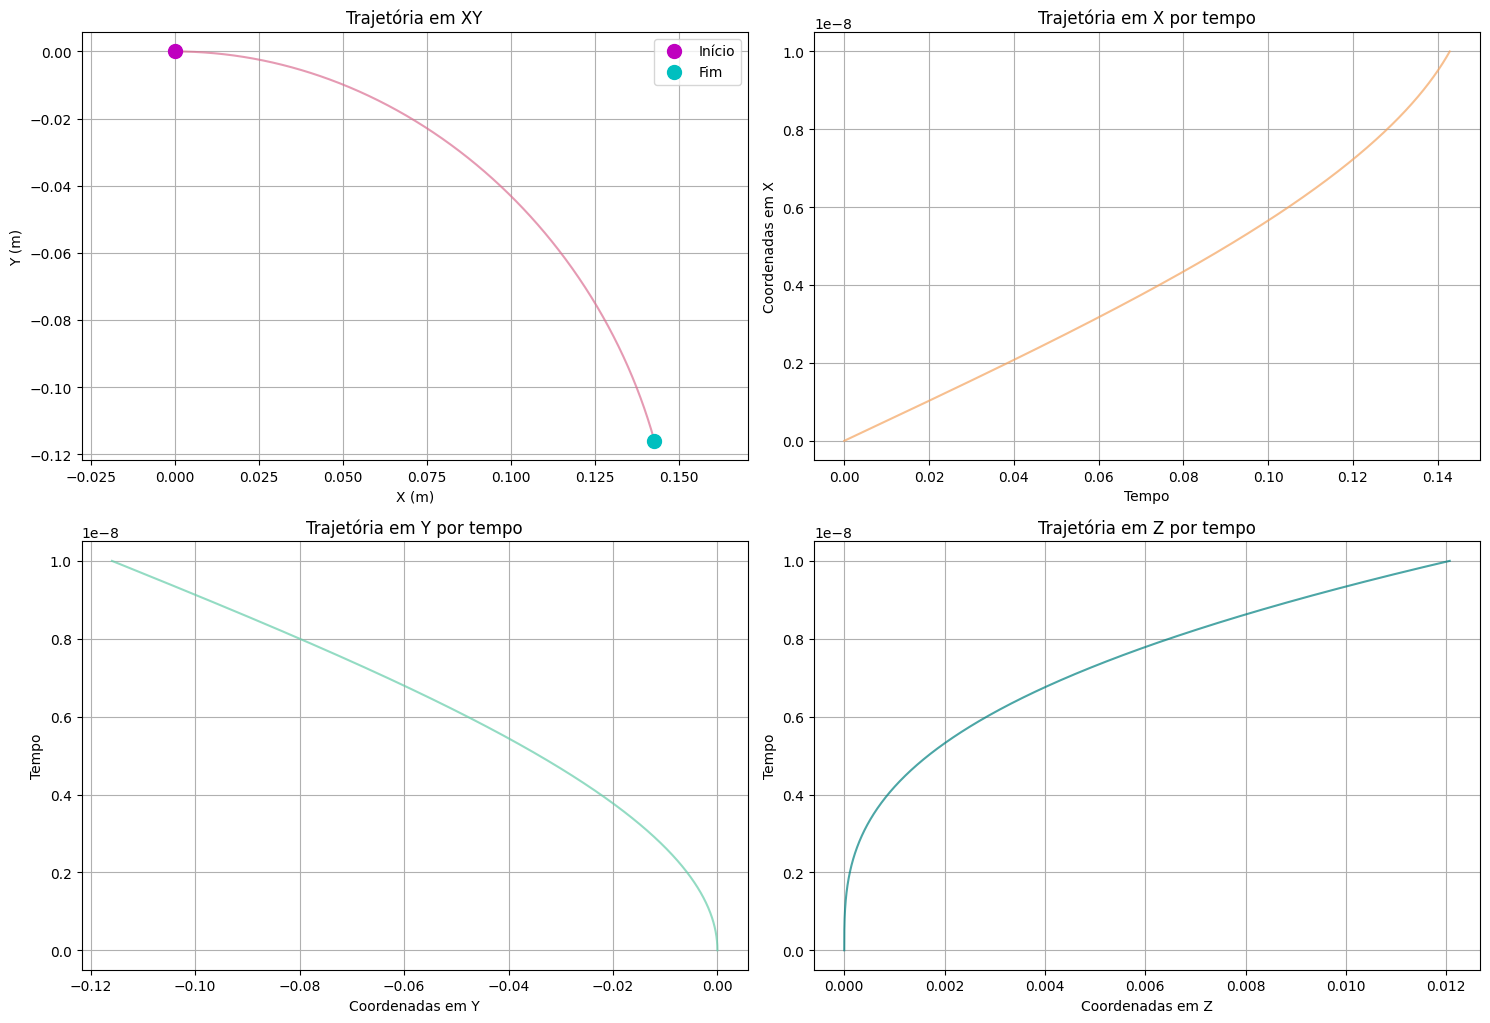

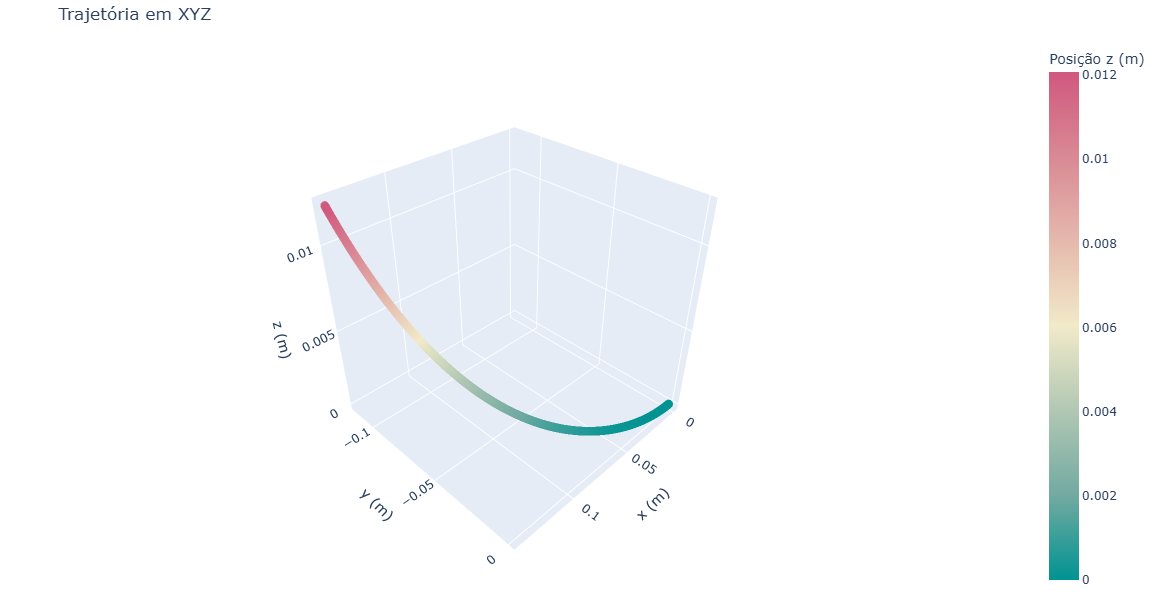

'done'

In [5]:
main_func(m, q, x0, y0, z0, b_field, e_field, Ec0, v_direction, step, total_t, output_file, txt_name)